In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

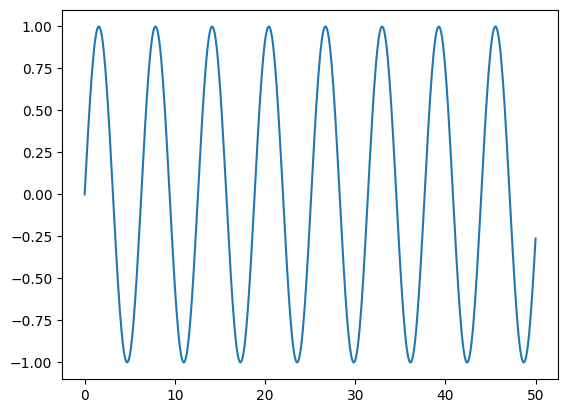

In [2]:
x=np.linspace(0,50,501)
y= np.sin(x)
plt.plot(x,y)

In [3]:
df= pd.DataFrame(data=y, index=x, columns=['Sine'])
df.head()

,Sine
0.0,0.000000
0.1,0.099833
0.2,0.198669
0.3,0.295520
0.4,0.389418


In [7]:
train = df.iloc[:len(df)-int(np.round((len(df)*0.1)))]
test = df.iloc[len(df)-int(np.round((len(df)*0.1))):]
train

,Sine
0.0,0.000000
0.1,0.099833
0.2,0.198669
0.3,0.295520
0.4,0.389418
...,...
44.6,0.579164
44.7,0.657656
44.8,0.729577
44.9,0.794208


In [8]:
#scaling our  the target column
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
scaled_train = scaler.fit_transform(train)
scaled_test = scaler.transform(test)


In [9]:
# our generator to provide the data in batches
from tensorflow import keras
from keras.preprocessing.sequence import TimeseriesGenerator

length = 49
generator = TimeseriesGenerator(scaled_train, scaled_train, length=length, batch_size=1)
validation_generator = TimeseriesGenerator(scaled_test, scaled_test, length=length, batch_size=1)


Creating our RNN using LSTM

In [10]:
from keras.models import Sequential
from keras.layers import Dense, LSTM

n_features =1
model = Sequential()
model.add(LSTM(units=50, input_shape=((length, n_features))))
model.add(Dense(units=1))
model.compile(loss='mse', optimizer='adam')


In [11]:
from keras.callbacks import EarlyStopping
early_stopping = EarlyStopping(patience=3)
model.fit_generator(generator=generator, callbacks=[early_stopping], validation_data=validation_generator, epochs=20)

Epoch 1/20


C:\Users\dell\AppData\Local\Temp\ipykernel_11236\4007343436.py:3: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  model.fit_generator(generator=generator, callbacks=[early_stopping], validation_data=validation_generator, epochs=20)


402/402 [==============================] - 15s 28ms/step - loss: 0.0156 - val_loss: 1.1694e-04
Epoch 2/20
402/402 [==============================] - 10s 25ms/step - loss: 3.0748e-04 - val_loss: 4.0691e-05
Epoch 3/20
402/402 [==============================] - 10s 26ms/step - loss: 2.1757e-04 - val_loss: 6.6863e-05
Epoch 4/20
402/402 [==============================] - 14s 34ms/step - loss: 4.0726e-04 - val_loss: 4.2693e-05
Epoch 5/20
402/402 [==============================] - 11s 27ms/step - loss: 7.3696e-05 - val_loss: 5.2072e-05


In [12]:
#evaluating model's performance
test_predictions=[]
first_eval_batch = scaled_train[-length:]
current_batch = first_eval_batch.reshape((1,length, n_features))

for i in range(len(test)):
    current_pred = model.predict(current_batch)[0]
    test_predictions.append(current_pred)
    current_batch = np.append(current_batch[:,1:,:], [[current_pred]], axis=1)

1/1 [==============================] - 0s 56ms/step


In [13]:
true_preds = scaler.inverse_transform(test_predictions)
test['Prediction'] = true_preds


C:\Users\dell\AppData\Local\Temp\ipykernel_11236\2339187165.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['Prediction'] = true_preds


<AxesSubplot: >

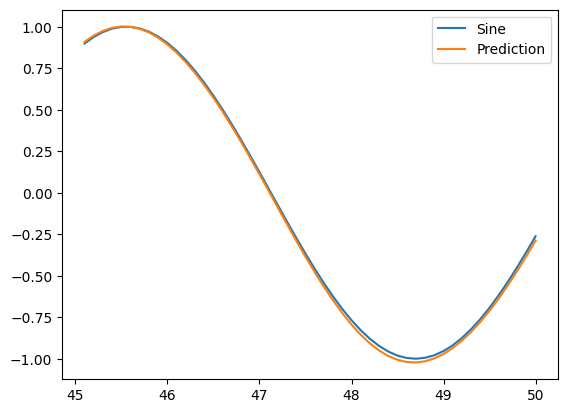

In [14]:
test[['Sine', 'Prediction']].plot()

Now we forecast into the unknown future

In [15]:
#for this we need to train our model on the entire dataset
full_scaler = MinMaxScaler()
scaled_full_data = full_scaler.fit_transform(df)


In [16]:
generator= TimeseriesGenerator(scaled_full_data,scaled_full_data, length=length, batch_size=1)


In [17]:
model = Sequential()
model.add(LSTM(50,input_shape=(length, n_features)))
model.add(Dense(1))
model.compile(loss='mse',optimizer='adam')


In [18]:
model.fit(generator,callbacks=[early_stopping], epochs=6)

Epoch 1/6
452/452 [==============================] - 14s 23ms/step - loss: 0.0178
Epoch 2/6
452/452 [==============================] - 10s 23ms/step - loss: 7.8057e-05
Epoch 3/6
452/452 [==============================] - 11s 24ms/step - loss: 3.4278e-04
Epoch 4/6
452/452 [==============================] - 12s 27ms/step - loss: 1.0291e-04
Epoch 5/6
452/452 [==============================] - 11s 25ms/step - loss: 5.7432e-05
Epoch 6/6
452/452 [==============================] - 12s 26ms/step - loss: 4.4348e-04


In [19]:
#evaluating model's performance
test_predictions=[]
first_eval_batch = scaled_full_data[-length:]
current_batch = first_eval_batch.reshape((1,length, n_features))

for i in range(25):
    current_pred = model.predict(current_batch)[0]
    test_predictions.append(current_pred)
    current_batch = np.append(current_batch[:,1:,:], [[current_pred]], axis=1)

1/1 [==============================] - 0s 48ms/step


In [20]:
forecast = full_scaler.inverse_transform(test_predictions)

In [23]:
forecast_index= np.arange(50.1,52.6, 0.1)

In [21]:
25*0.1

2.5

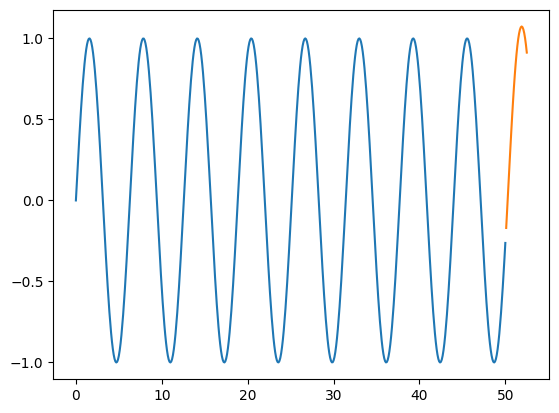

In [24]:
plt.plot(df.index,df['Sine'])
plt.plot(forecast_index, forecast)